# Improving estimation of expectation values using wire cutting
*Usage estimate: 1 minute on IBM Brisbane (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

Circuit-knitting is an umbrella term which encapsulates various methods of partitioning a circuit in multiple smaller subcircuits involving fewer gates and/or qubits. Each of the subcircuits can be executed independently and the final result is obtained via some classical postprocessing over the outcome of each subcircuit. This technique is accessible in the [circuit cutting Qiskit addon](https://qiskit.github.io/qiskit-addon-cutting/index.html), a detailed explaination of the technique is given in the [docs](https://qiskit.github.io/qiskit-addon-cutting/explanation/index.html) along with other [introductory material](https://qiskit.github.io/qiskit-addon-cutting/tutorials/index.html).

This notebook deals with a method called <b>wire cutting</b> where the circuit is partitioned along the wire [\[1\], \[2\]](#references). Note that, partitioning is simple in classical circuits since the outcome at the point of partition can be determined deterministically, and is either 0 or 1. However, the state of the qubit at the point of the cut is, in general, a mixed state. Therefore, each subcircuit needs to be measured multiple times in different basis (usually a tomographically complete set of basis such as the Pauli basis [\[3\], \[4\]](#references) and correspondingly prepared in its eigenstate. The Figure below (<i>courtesy: PhD Thesis, Ritajit Majumdar</i>) shows an example of wire cutting for a 4-qubit GHZ state into three subcircuits. Here $M_j$ denote a set of basis (usually Pauli X, Y and Z) and $P_i$ denote a set of eigenstates (usually $|0\rangle$, $|1\rangle$, $|+\rangle$ and $|+i\rangle$).

![wc-1.png](/images/tutorials/wire-cutting-to-improve-performance/0ce8857b-7f5f-400e-8536-6a496c724d50.avif)
![wc-2.png](/images/tutorials/wire-cutting-to-improve-performance/cbce4455-4794-4c81-8630-3e3993e1b29f.avif)

Since each subcircuit has fewer qubits and/or gates, they are expected to be less amenable to noise. This notebook shows an example where this method can be used to effectively suppress the noise in the system.

## Requirements
Before starting this tutorial, be sure you have the following installed:

- Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime 0.22 or later ( `pip install qiskit-ibm-runtime` )
- Circuit cutting Qiskit addon 0.9.0 or later (`pip install qiskit-addon-cutting`)

We shall consider a Many Body Localization (MBL) circuit for this notebook. The MBL circuit is a hardware-efficient circuit and is parameterized by two parameters $\theta$ and $\vec{\phi}$. When $\theta$ is set to $0$ and the initial state is prepared in $|0\rangle$ for all the qubits, the ideal expectation value of $\langle Z_i \rangle$ is $+1$ for every qubit site $i$ irrespective of the values of $\vec{\phi}$. You can check more details on MBL circuits in <a href="https://arxiv.org/abs/2307.07552">this paper</a>.

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qiskit.quantum_info import PauliList, SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.result import sampled_expectation_value

from qiskit_addon_cutting.instructions import CutWire
from qiskit_addon_cutting import (
    cut_wires,
    expand_observables,
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2, Batch


class MBLChainCircuit(QuantumCircuit):
    def __init__(
        self, num_qubits: int, depth: int, use_cut: bool = False
    ) -> None:
        super().__init__(
            num_qubits, name=f"MBLChainCircuit<{num_qubits}, {depth}>"
        )
        evolution = MBLChainEvolution(num_qubits, depth, use_cut)
        self.compose(evolution, inplace=True)


class MBLChainEvolution(QuantumCircuit):
    def __init__(self, num_qubits: int, depth: int, use_cut) -> None:
        super().__init__(
            num_qubits, name=f"MBLChainEvolution<{num_qubits}, {depth}>"
        )

        theta = Parameter("θ")
        phis = ParameterVector("φ", num_qubits)

        for layer in range(depth):
            layer_parity = layer % 2
            # print("layer parity", layer_parity)
            for qubit in range(layer_parity, num_qubits - 1, 2):
                # print(qubit)
                self.cz(qubit, qubit + 1)
                self.u(theta, 0, np.pi, qubit)
                self.u(theta, 0, np.pi, qubit + 1)
                if (
                    use_cut
                    and layer_parity == 0
                    and (
                        qubit == num_qubits // 2 - 1
                        or qubit == num_qubits // 2
                    )
                ):
                    self.append(CutWire(), [num_qubits // 2])
                if use_cut and layer < depth - 1 and layer_parity == 1:
                    if qubit == num_qubits // 2:
                        self.append(CutWire(), [qubit])
            for qubit in range(num_qubits):
                self.p(phis[qubit], qubit)

## Part I. Small scale example

### Step 1: Map classical inputs to a quantum problem

Initially we build a template circuit without any specific parameter values. We also provide placeholders, called `CutWire`, to annotate the position of cuts. For the small scale example we consider a 10-qubit MBL circuit.

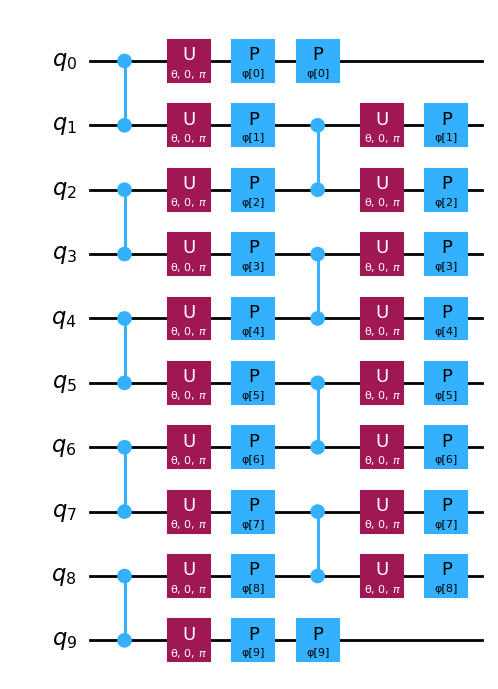

In [68]:
num_qubits = 10
depth = 2
mbl = MBLChainCircuit(num_qubits, depth)
mbl.draw("mpl", fold=-1)

Recall that we aim to find the expectation value of the observable $\frac{1}{n}\sum_{i=1} ^n Z_i$ when $\theta=0$. We shall put some random values for the parameter $\vec{\phi}$.

In [69]:
phis = list(np.random.rand(mbl.num_parameters - 1))
theta = [0]
params = theta + phis
params

[0,
 0.2376615174332788,
 0.28244289857682414,
 0.019248960591717768,
 0.46140600996102477,
 0.31408025180068433,
 0.718184005135733,
 0.991153920182475,
 0.09289485768301442,
 0.8857848280067783,
 0.6177529765767047]

Now we annotate the circuit for cutting by inserting proper **CutWire** to create two roughly equal cuts. We set `use_cut=True` in the function, and allow it to annotate after $\frac{n}{2}$ qubits, $n$ being the number of qubits in the original circuit.

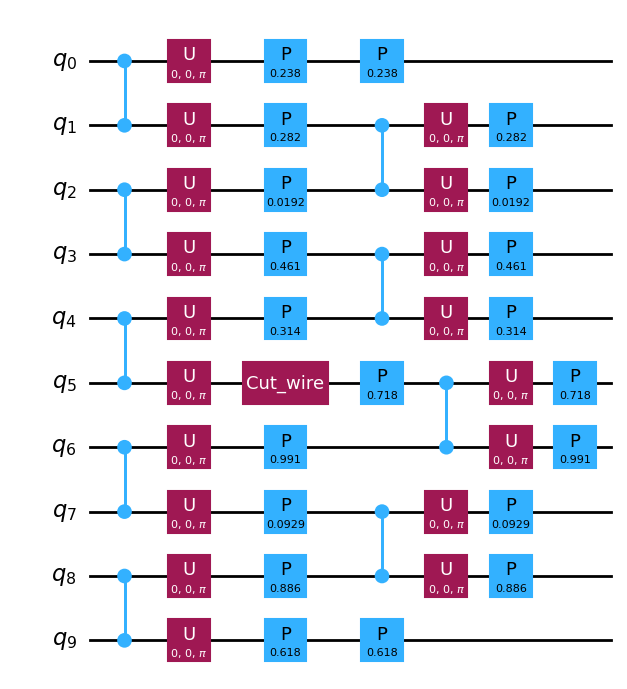

In [70]:
mbl_cut = MBLChainCircuit(num_qubits, depth, use_cut=True)
mbl_cut.assign_parameters(params, inplace=True)
mbl_cut.draw("mpl", fold=-1)

### Step 2: Optimize problem for quantum hardware execution

Next we cut the circuit into two smaller subcircuits. For this example, we stick to only 2 subcircuits. For this, we use the <a href="https://qiskit.github.io/qiskit-addon-cutting/">Qiskit Addon: Circuit Cutting</a>.

#### Cut the circuit into smaller subcircuits

Cutting the wire at a point increases the qubit count by one. Apart from the original qubit, there is now an extra qubit as a placeholder to the circuit after cutting. The following image gives a representation:

![wc-4.png](/images/tutorials/wire-cutting-to-improve-performance/dfc5f923-e507-4873-888e-d90e1618be3a.avif)

This Addon uses the function `cut_wires` to account for the extra qubits arising due to cutting.

In [ ]:
mbl_move = cut_wires(mbl_cut)

#### Create and expand the observables

Now we construct the observable $M_z = \frac{1}{n}\sum_{i=1}^n \langle Z_i \rangle$. Since the ideal outcome of $\langle Z_i \rangle$ for each $i$ is $+1$, the ideal outcome of $M_z$ is also $+1$.

In [ ]:
observable = PauliList(
    ["I" * i + "Z" + "I" * (num_qubits - i - 1) for i in range(num_qubits)]
)
observable

PauliList(['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII',
           'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII',
           'IIIIIIIIZI', 'IIIIIIIIIZ'])

However, note that the number of qubits in the circuit has increased after inserting the virtual 2-qubit `Move` operations after cutting. Therefore, we need to expand the observables as well by inserting identities to assert to the current circuit.

In [ ]:
new_obs = expand_observables(observable, mbl, mbl_move)
new_obs

PauliList(['ZIIIIIIIIII', 'IZIIIIIIIII', 'IIZIIIIIIII', 'IIIZIIIIIII',
           'IIIIZIIIIII', 'IIIIIIZIIII', 'IIIIIIIZIII', 'IIIIIIIIZII',
           'IIIIIIIIIZI', 'IIIIIIIIIIZ'])

Note that each observable has now expanded to accommodate 7 qubits, as in the circuit with `Move` operation, instead of the original 6 qubits. Now we shall partition the circuit into two subcircuits.

In [ ]:
partitioned_problem = partition_problem(circuit=mbl_move, observables=new_obs)

Let us visualize the subcircuits

In [9]:
subcircuits = partitioned_problem.subcircuits

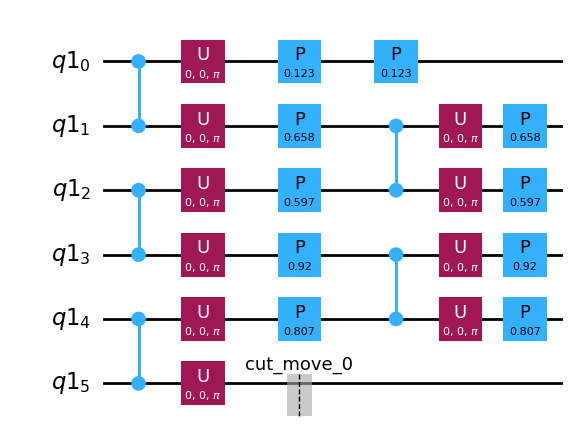

In [10]:
subcircuits[0].draw("mpl", fold=-1)

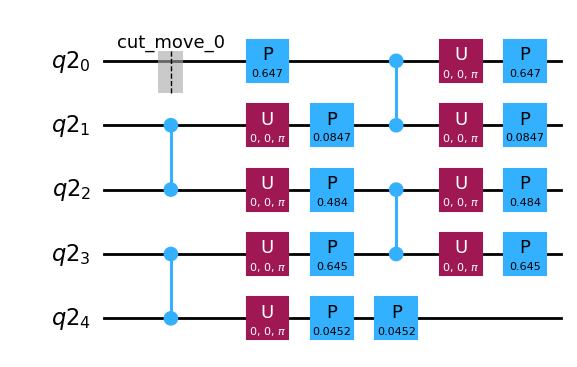

In [11]:
subcircuits[1].draw("mpl", fold=-1)

The observables have been partitioned as well to fit the subcircuits

In [12]:
subobservables = partitioned_problem.subobservables
subobservables

{0: PauliList(['IIIIII', 'IIIIII', 'IIIIII', 'IIIIII', 'IIIIII', 'IZIIII',
            'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ']),
 1: PauliList(['ZIIII', 'IZIII', 'IIZII', 'IIIZI', 'IIIIZ', 'IIIII', 'IIIII',
            'IIIII', 'IIIII', 'IIIII'])}

Note that each subcircuit leads to a number of samples. The reconstruction takes into account the outcome of each of these samples. Each of these samples is termed a `subexperiment`.

Extending the observable using the `Move` operation requires a `PauliList` data structure. We can also create the $M_z$ observable in the more generic `SparsePauliOp` data structure which will be useful later during reconstruction of the subexperiments.

In [ ]:
M_z = SparsePauliOp(
    ["I" * i + "Z" + "I" * (num_qubits - i - 1) for i in range(num_qubits)],
    coeffs=[1 / num_qubits] * num_qubits,
)
M_z

SparsePauliOp(['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'],
              coeffs=[0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j,
 0.1+0.j, 0.1+0.j])

In [ ]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=np.inf,
)

Let us see two examples where the cut qubits are measured in two different basis. First, it is measured in normal Z basis, and next it is measured in X basis.

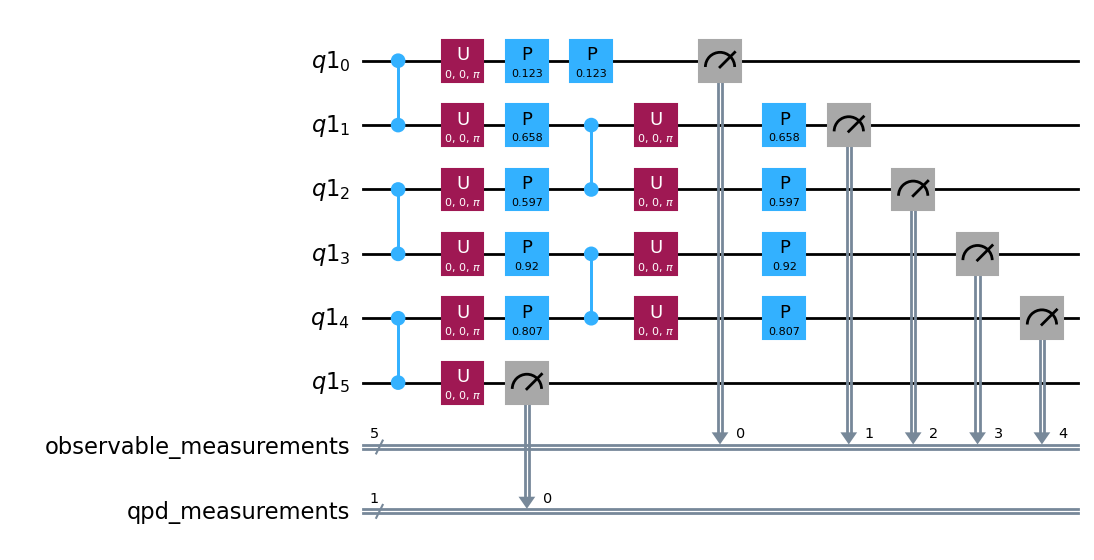

In [15]:
subexperiments[0][6].draw("mpl", fold=-1)

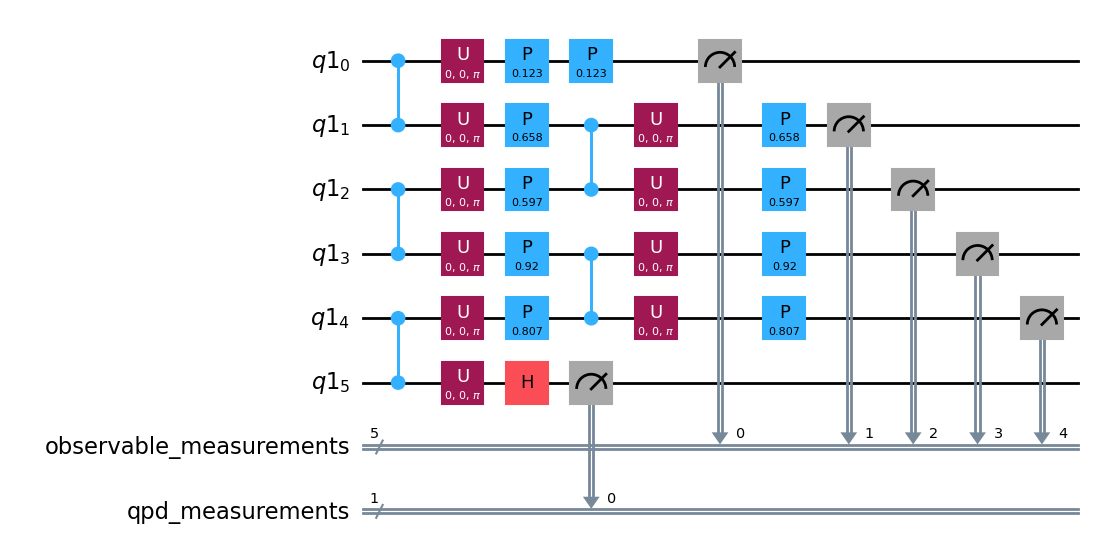

In [16]:
subexperiments[0][2].draw("mpl", fold=-1)

#### Transpile each subexperiment

Currently we need to transpile our circuits before submitting them for execution. Therefore, we shall transpile each circuit in the subexperiments first.

In [ ]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)

Now we need to transpile each of the circuits in the subexperiments. For that we first create a pass manager, and then use it to transpile each of the circuits.

In [ ]:
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)

In [19]:
isa_subexperiments = {
    label: pm.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

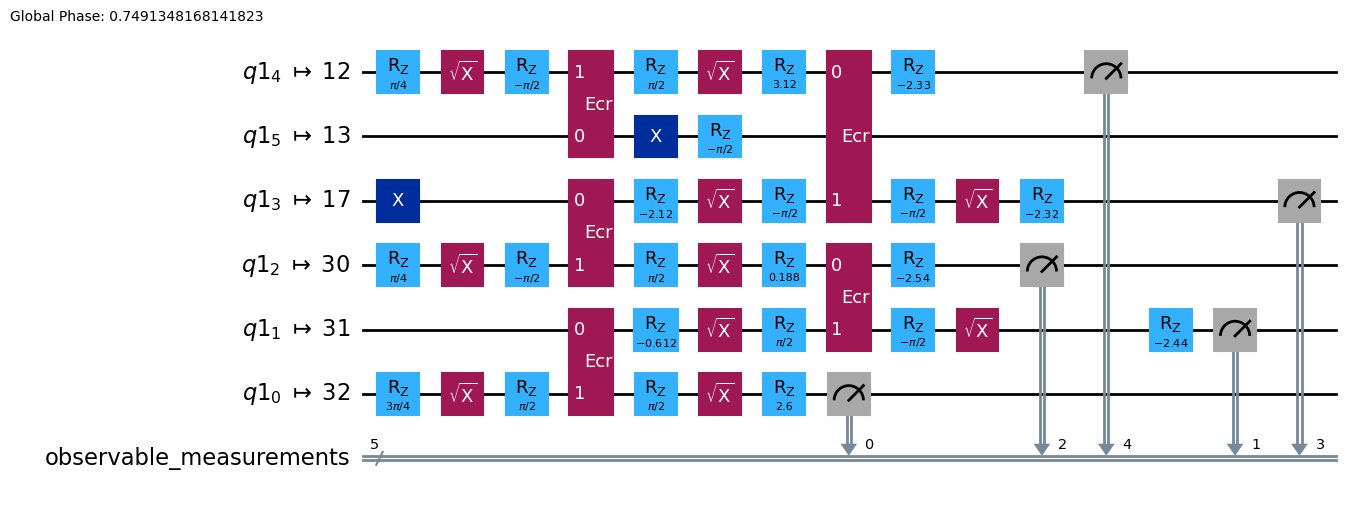

In [20]:
isa_subexperiments[0][0].draw("mpl", fold=-1, idle_wires=False)

### Step 3: Execute using Qiskit primitives

Now we shall execute each circuit in subexperiment. `Qiskit-addon-cutting` uses `SamplerV2` to execute the subexperiments.

In [ ]:
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

### Step 4: Post-process and return result in desired classical format

Once the circuits have been executed, we now need to retrieve the results and reconstruct the expectation value for the uncut circuit and the original observable.

In [22]:
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

In [ ]:
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
reconstructed_expval = np.dot(reconstructed_expval_terms, M_z.coeffs).real
reconstructed_expval

0.9674376845359803

#### Cross verify

Let us now execute the circuit without cutting and check the outcome there. Note that for execution of the uncut circuit we can directly use `EstimatorV2` for calculating the expectation values. But we shall use the same `Primitive` throughout. So we shall use `SamplerV2` to get the probability distribution and calculate the expectation value using the `sampled_expectation_value` function.

First we need to transpile the uncut `mbl` circuit.

In [24]:
sampler = SamplerV2(mode=backend)

if mbl.num_clbits == 0:
    mbl.measure_all()
isa_mbl = pm.run(mbl)

Next we construct the `pub` and run the uncut circuit.

In [ ]:
pub = (isa_mbl, params)
uncut_job = sampler.run([pub])

In [25]:
uncut_counts = uncut_job.result()[0].data.meas.get_counts()

In [ ]:
uncut_expval = sampled_expectation_value(uncut_counts, M_z)
uncut_expval

0.9498046875000001

We note that the expectation value obtained via wire cutting is closer to the ideal value of $+1$ than the uncut one. Let us now scale up the size of the problem.

## Part II. Scale it up!

Previously, we showed the results for a 10-qubit MBL circuit. Next, we show that the improvement in expectation value is also obtained for larger circuits. To show that, we repeat the process for a 60-qubit MBL circuit.

### Step 1: Map classical inputs to a quantum problem

In [29]:
num_qubits = 60
depth = 2
mbl = MBLChainCircuit(num_qubits, depth)

We create a random set of values for $\vec{\phi}$

In [ ]:
phis = list(np.random.rand(mbl.num_parameters - 1))
theta = [0]
params = theta + phis

Next we construct the cut circuit

In [ ]:
mbl_cut = MBLChainCircuit(num_qubits, depth, use_cut=True)
mbl_cut.assign_parameters(params, inplace=True)
mbl_cut.draw("mpl", fold=-1)

### Step 2: Optimize problem for quantum hardware execution

As shown for the small scale example, we partition the circuit and the observable for the cutting experiments.

In [32]:
mbl_move = cut_wires(mbl_cut)

# Define observable
observable = PauliList(
    ["I" * i + "Z" + "I" * (num_qubits - i - 1) for i in range(num_qubits)]
)
new_obs = expand_observables(observable, mbl, mbl_move)

# Partition the circuit into subcircuits
partitioned_problem = partition_problem(circuit=mbl_move, observables=new_obs)

# Get subcircuits
subcircuits = partitioned_problem.subcircuits

In [ ]:
subobservables = partitioned_problem.subobservables

We also create a `SparsePauliOp` object for the observable with proper co-efficients.

In [ ]:
M_z = SparsePauliOp(
    ["I" * i + "Z" + "I" * (num_qubits - i - 1) for i in range(num_qubits)],
    coeffs=[1 / num_qubits] * num_qubits,
)

Next we generate the subexperiments and transpile each circuit in the subexperiment.

In [38]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=np.inf,
)

In [39]:
isa_subexperiments = {
    label: pm.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

### Step 3: Execute using Qiskit primitives

We use the `Batch` mode to execute all the circuits in the subexperiments.

In [43]:
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

### Step 4: Post-process and return result in desired classical format

Let us now retrieve the results for each circuit in the subexperiment and reconstruct the expectation value corresponding to the uncut circuit and the original observable.

In [44]:
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

In [45]:
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
reconstructed_expval = np.dot(reconstructed_expval_terms, M_z.coeffs).real
reconstructed_expval

0.9631355921427409

#### Cross verify

As in the small scale example, we shall once more obtain the expectation value by executing the uncut circuit, and compare the result with circuit cutting. We shall use the `SamplerV2` to maintain uniformity in the use of Primitives.

In [48]:
sampler = SamplerV2(mode=backend)

if mbl.num_clbits == 0:
    mbl.measure_all()
isa_mbl = pm.run(mbl)

pub = (isa_mbl, params)
uncut_job = sampler.run([pub])

In [49]:
uncut_counts = uncut_job.result()[0].data.meas.get_counts()
uncut_expval = sampled_expectation_value(uncut_counts, M_z)
uncut_expval

0.9426757812499998

#### Visualize

Let us visualize the improvement obtained in the expectation value by using wire cutting.

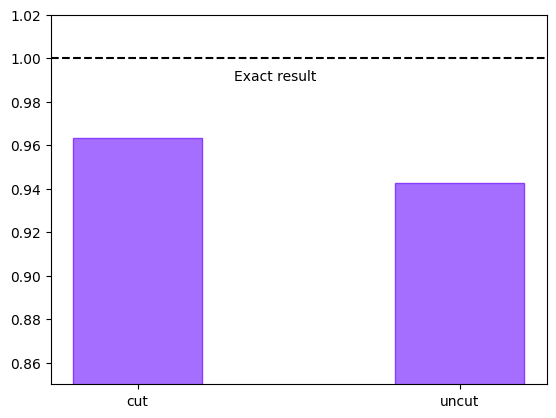

In [ ]:
ax = plt.gca()
methods = ["cut", "uncut"]
values = [reconstructed_expval, uncut_expval]

plt.bar(methods, values, color="#a56eff", width=0.4, edgecolor="#8a3ffc")
plt.axhline(y=1, color="k", linestyle="--")
ax.set_ylim([0.85, 1.02])
plt.text(0.3, 0.99, "Exact result")
plt.show()

#### Inference

We observe that both in the small and large scale problems wire cutting leads to a better result than the uncut one. Note that no error mitigation techniques have been used for these experiments. Therefore, the improvement in result that has been obtained is only due to wire cutting. It may be possible to further improve the results using different mitigation methods together with circuit cutting.

Moreover, in this notebook, we computed both the subcircuits on the same hardware. In [\[5\], \[6\]](#references), the authors shows a method to distribute the subcircuits on different hardware using noise information in order to maximize the noise suppression, and parallelize the process.

## Appendix: resource scaling consideration

The number of circuits to be executed increases with the number of cuts. Therefore, while many cuts can produce small subcircuits, thus further improving the performance, it also leads to a significantly high number of circuit executions, which may not be practical for most cases. Below, we show an example of the number of subcircuits corresponding to the number of cuts for a 50-qubit circuit.

![wc-5.png](/images/tutorials/wire-cutting-to-improve-performance/5c6ea4da-bbd8-47f9-ac48-e438cc59a11d.avif)

We note that even for 5 cuts the number of subexperiments is around 200k. Therefore, circuit cutting should be used only when the number of cuts is small.

### One example of cut-friendly and cut-unfriendly circuits each

#### Cut-friendly circuit

As noted earlier, a circuit is cut-friendly when the circuit can be partitioned into smaller disjoint subcircuits with a small number of cuts. Any hardware-efficient circuit, i.e., a circuit which requires little to no SWAP gates when mapped to the hardware coupling map, is, in general, cut-friendly. Below, we show an example of an excitation preserving ansatz, which is used in Quantum Chemistry. Note that such a circuit can be partitioned into two subcircuits with a single cut irrespective of the number of qubits.

![wc-6.png](/images/tutorials/wire-cutting-to-improve-performance/c122a418-b914-41e7-a1aa-00eb1eec5b87.avif)

#### Cut-unfriendly circuit

A circuit is cut-unfriendly if, in general, the number of cuts required to form disjoint partitions grow significantly with the depth of the number of qubits. Recall that with each cut an extra qubit is required. So with the number of cuts, the effective number of qubits also increase. Below we show an example of a 3-qubit Grover circuit with a possible cutting instance.

![wc-7.png](/images/tutorials/wire-cutting-to-improve-performance/b31dc57e-e6d7-49fd-9f46-304a328b3764.avif)

We note that three cuts are required, and the cut is more vertical than horizontal. This means, that the number of cuts is expected to scale linearly with the number of qubits, which is not amenable for cutting.

## References


[1] Peng, T., Harrow, A. W., Ozols, M., & Wu, X. (2020). Simulating large quantum circuits on a small quantum computer. Physical review letters, 125(15), 150504.

[2] Tang, W., Tomesh, T., Suchara, M., Larson, J., & Martonosi, M. (2021, April). Cutqc: using small quantum computers for large quantum circuit evaluations. In Proceedings of the 26th ACM International conference on architectural support for programming languages and operating systems (pp. 473-486).

[3]  Perlin, M. A., Saleem, Z. H., Suchara, M., & Osborn, J. C. (2021). Quantum circuit cutting with maximum-likelihood tomography. npj Quantum Information, 7(1), 64.

[4]  Majumdar, R., & Wood, C. J. (2022). Error mitigated quantum circuit cutting. arXiv preprint arXiv:2211.13431.

[5]  Khare, T., Majumdar, R., Sangle, R., Ray, A., Seshadri, P. V., & Simmhan, Y. (2023). Parallelizing Quantum-Classical Workloads: Profiling the Impact of Splitting Techniques. In 2023 IEEE International Conference on Quantum Computing and Engineering (QCE) (Vol. 1, pp. 990-1000). IEEE.

[6]  Bhoumik, D., Majumdar, R., Saha, A., & Sur-Kolay, S. (2023). Distributed Scheduling of Quantum Circuits with Noise and Time Optimization. arXiv preprint arXiv:2309.06005.

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_3BLFkNVEuh0QBWm)

© IBM Corp. 2024, 2025